In [1]:
%matplotlib inline
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from math import log
from sklearn.base import BaseEstimator
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, make_scorer

/home/pokrasko/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def add_map(mp, key, val):
    if key not in mp:
        mp[key] = val
    else:
        mp[key] += val

def make_data_entry(filename):
    res = {}
    res['is_spam'] = "spmsg" in filename
    with open(filename, 'r') as f:
        l = next(f)
        for n in l.split()[1:]:
            res[0, int(n)] = 1
        for l in f:
            for n in l.split():
                res[1, int(n)] = 1
    return res    

def make_dataset():
    files = glob.glob('data/part*/*.txt')
    entries = list(map(make_data_entry, files))
    return pd.DataFrame.from_dict(entries)

In [3]:
data = make_dataset().fillna(0)

In [4]:
data.head()

,is_spam,"(0, 14486)","(1, 14486)","(1, 80)","(1, 196)","(1, 64)","(1, 1896)","(1, 8962)","(1, 14328)","(1, 2130)",...,"(1, 15561)","(1, 15330)","(1, 11289)","(1, 547)","(1, 15318)","(1, 238)","(1, 21957)","(1, 1402)","(1, 17219)","(1, 19609)"
0,True,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,True,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def accuracy_score(true, predicted):
    return (predicted == true).sum() / len(true)

def f1_score(true, predicted):
    tp = ((predicted == 1) * (true == 1)).sum()
    rec = tp / (true == 1).sum()
    prec = tp / (predicted == 1).sum()
    return 2 * prec * rec / (prec + rec)

In [6]:
class NaiveBayes(BaseEstimator):
    
    def __init__(self, smooth_coef=1e-5, lambdas=None):
        self.smooth_coef = smooth_coef
        self.lambdas = lambdas
        
    def fit(self, X, y):
        total_counts = np.sum(X, axis=0)
        total_words = np.sum(total_counts)
        classes = np.unique(y)
        
        if self.lambdas is None:
            self.lambdas = np.ones(classes.shape[0])
            
        self.classes = classes
        self.word_probas = np.zeros((classes.shape[0], total_counts.shape[0]))
        self.class_probas = np.zeros(classes.shape[0])
        for cl in classes:
            cl_count = y[y == cl].shape[0]

            # smooth_coef затем, чтобы не вышло нулевых вероятностей
            self.word_probas[cl] = (np.sum(X[y == cl], axis=0) + self.smooth_coef) / (cl_count + self.smooth_coef * y.shape[0])
            self.class_probas[cl] = float(cl_count) / y.shape[0]
    
    def class_log_proba(self, x, cl):
        return self.lambdas[cl] + np.log(self.class_probas[cl]) + np.sum(np.log(self.word_probas[cl][x > 0]))
    
    def predict_log_proba(self, X):
        probas = np.zeros((X.shape[0], self.classes.shape[0]))
        for i in np.arange(0, X.shape[0]):
            for cl in self.classes:
                probas[i][cl] = self.class_log_proba(X[i], cl)
        return probas
        
    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [7]:
X = data.drop('is_spam', axis=1).values
y = data['is_spam'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=43)

In [9]:
print(X.shape[0], X.shape[1])

1090 26282


In [10]:
nb = NaiveBayes()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred)

0.9678899082568807

In [12]:
f1_score(y_test, y_pred)

0.96373056994818662

In [13]:
cv_acc_scores = cross_val_score(NaiveBayes(), X, y, scoring=make_scorer(accuracy_score), cv=10)
cv_acc_scores.mean()

0.97981651376146794

In [14]:
cv_f1_scores = cross_val_score(NaiveBayes(), X, y, scoring=make_scorer(f1_score), cv=10)
cv_f1_scores.mean()

0.97705256603918078

In [15]:
confusion_matrix(y_test, y_pred)

array([[118,   2],
       [  5,  93]])

In [16]:
def class_accuracy(y_test, y_pred, cl):
    y_cl = y_test[y_test == cl]
    y_pr = y_pred[y_test == cl]
    return float(np.sum(y_cl == y_pr)) / y_cl.shape[0]

In [17]:
class_accuracy(y_test, y_pred, 0)

0.9833333333333333

In [18]:
class_accuracy(y_test, y_pred, 1)

0.9489795918367347

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 9.78 µs


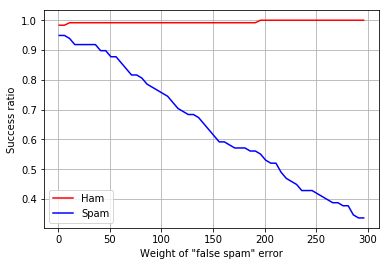

In [23]:
%time
ls = np.arange(1, 300, 5)
sc0 = []
sc1 = []

for l in ls:
    nbc = NaiveBayes(lambdas=[l, 1])
    nbc.fit(X_train, y_train)
    y_pred = nbc.predict(X_test)
    
    sc0.append(class_accuracy(y_test, y_pred, 0))
    sc1.append(class_accuracy(y_test, y_pred, 1))

plt.plot(ls, sc0, 'r-', ls, sc1, 'b-')
plt.xlabel('Weight of "false spam" error')
plt.ylabel('Success ratio')
plt.legend(['Ham', 'Spam'])
plt.grid()
plt.show()

In [29]:
nbc = NaiveBayes(lambdas=[500, 1])
nbc.fit(X_train, y_train)
y_pred = nbc.predict(X_test)
print('Ham recall: {}'.format(class_accuracy(y_test, y_pred, 0)))
print('Spam recall: {}'.format(class_accuracy(y_test, y_pred, 1)))

Ham recall: 1.0
Spam recall: 0.24489795918367346
